In [1]:
getwd()

[1] "/mnt/md0/isshamie/Projects/Mito_Trace/R_scripts/annotations"

## Creates binarized Seurat objects, integrates conditions and annotates genes by nearby peaks

In [2]:

# Input info
# outdir = "/mnt/md0/isshamie/Projects/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/annotation/gff_hg38_1_2/mergedSamples/"
# sample_names = "preB,postB"
# gff_id = "hg38_1_2"

outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b2/InputOnly/MTBlacklist_A2/data/annotation/gff_A2_black/mergedSamples"
sample_names = "Input"
gff_id = "A2_black" 


annotations_indir = "/mnt/md0/isshamie/Projects/Mito_Trace/data/processed/annotation_granges/"



# Parameters
nTop = 25000
lsi_start_comp = 2
to.filt.cells = "TRUE"


to.qc = FALSE
## QC parameters
# min_peak_region_fragments=1000
# max_peak_region_fragments=10000
# min_pct_reads_in_peaks=20
# max_blacklist_ratio=0.05
# max_nucleosome_signal=15
# min_TSS_enrichment=0.2

min_peak_region_fragments=10
max_peak_region_fragments=15000
min_pct_reads_in_peaks=15
max_blacklist_ratio=0.05
max_nucleosome_signal=4
min_TSS_enrichment=0.2

cores = 24


In [3]:
annotations <- readRDS(file.path(annotations_indir, paste0(gff_id, ".annotationGranges.rds")))

In [4]:
if ((to.filt.cells == "T") | (to.filt.cells == "TRUE")){
    to.filt.cells = TRUE
}else{to.filt.cells = FALSE}


In [5]:
sample_names <- unlist(strsplit(sample_names, ","))
sample_names

[1] "Input"

In [6]:
library(repr)
options(repr.plot.width=12, repr.plot.height=12)

library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library(dplyr)
library("patchwork")
library(future)
library(Rsamtools)


plan("multiprocess", workers = cores)
options(future.globals.maxSize = 8000 * 1024^2)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
#plan("multiprocess", workers = workers)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Attaching SeuratObject

Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required pa

In [7]:
allSE <- readRDS(file.path(outdir, paste0("allSamples.rds")))

In [8]:
allSE

[[1]]
An object of class Seurat 
93059 features across 4761 samples within 1 assay 
Active assay: ATAC (93059 features, 0 variable features)


## Filter cells if parameters there

In [9]:
filtCells <- function(se, min_peak_region_fragments=10,
                      max_peak_region_fragments=15000,
                     min_pct_reads_in_peaks=15,
                     max_blacklist_ratio=0.05,
                     max_nucleosome_signal=4,
                     min_TSS_enrichment=2){
    print('se before filt')
    print(se)
    se <- subset(
      x = se,
      subset = peak_region_fragments > min_peak_region_fragments &
               peak_region_fragments < max_peak_region_fragments &
               pct_reads_in_peaks > min_pct_reads_in_peaks &
               blacklist_ratio < max_blacklist_ratio &
               nucleosome_signal < max_nucleosome_signal  &
               TSS.enrichment > min_TSS_enrichment
    )
    print('se after filt')
    print(se)
    return(se)
}

In [10]:
if (to.filt.cells){
    allSE <- lapply(allSE, filtCells,
                    min_peak_region_fragments=min_peak_region_fragments,
                    max_peak_region_fragments=max_peak_region_fragments,
                    min_pct_reads_in_peaks=min_pct_reads_in_peaks,
                    max_blacklist_ratio=max_blacklist_ratio,
                    max_nucleosome_signal=max_nucleosome_signal,
                    min_TSS_enrichment=min_TSS_enrichment)
}

[1] "se before filt"
An object of class Seurat 
93059 features across 4761 samples within 1 assay 
Active assay: ATAC (93059 features, 0 variable features)
[1] "se after filt"
An object of class Seurat 
93059 features across 4657 samples within 1 assay 
Active assay: ATAC (93059 features, 0 variable features)


In [11]:
allSE

[[1]]
An object of class Seurat 
93059 features across 4657 samples within 1 assay 
Active assay: ATAC (93059 features, 0 variable features)


# Merge:
- get umap and clusters

In [12]:
# Add sample names to cell prefix here.
for (i in 1:length(allSE)){
    print(i)
    curr.SE <- allSE[[i]]
    allSE[[i]] <- RenameCells(allSE[[i]], add.cell.id=curr.SE$orig.ident[[1]])
}

[1] 1


In [13]:
allSE[[1]][["ATAC"]]

ChromatinAssay data with 93059 features for 4657 cells
Variable features: 0 
Genome: 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

In [14]:
combined = allSE[[1]]
combined <- FindTopFeatures(combined, min.cutoff = 20)
combined

An object of class Seurat 
93059 features across 4657 samples within 1 assay 
Active assay: ATAC (93059 features, 87814 variable features)

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.



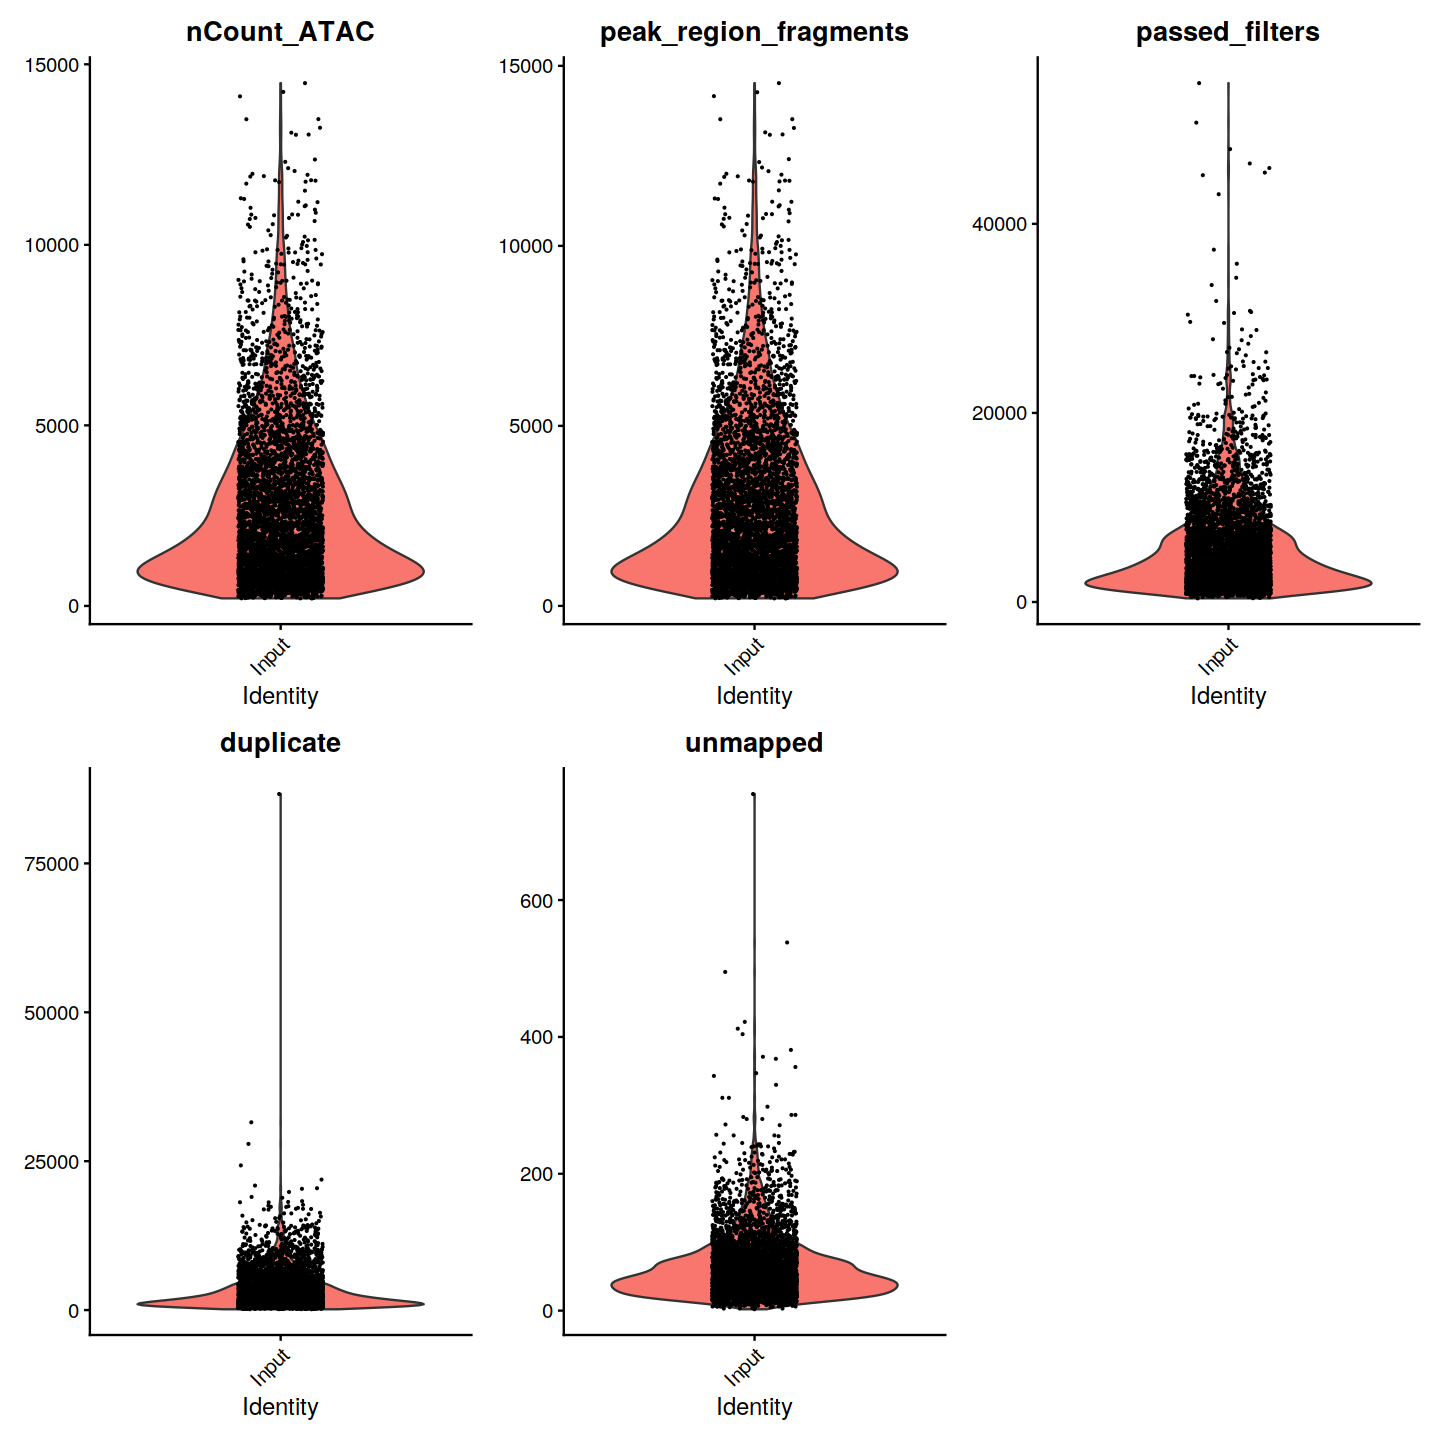

In [15]:
combined$orig.ident <- factor(combined$orig.ident, levels = sample_names)

VlnPlot(
  object = combined,
  features = c('nCount_ATAC', 'peak_region_fragments', 'passed_filters',
               'duplicate', 'unmapped'),
  split.by = "orig.ident",
  pt.size = 0.1,
  ncol = 3
)


Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
13:30:09 UMAP embedding parameters a = 0.9922 b = 1.112

13:30:09 Read 4657 rows and found 49 numeric columns

13:30:09 Using Annoy for neighbor search, n_neighbors = 30

13:30:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:30:09 Writing NN index file to temp file /tmp/RtmpnGyMle/file21e729247006f3

13:30:09 Searching Annoy index using 24 threads, search_k = 3000

13:30:10 Annoy recall = 100%

13:30:11 Commencin

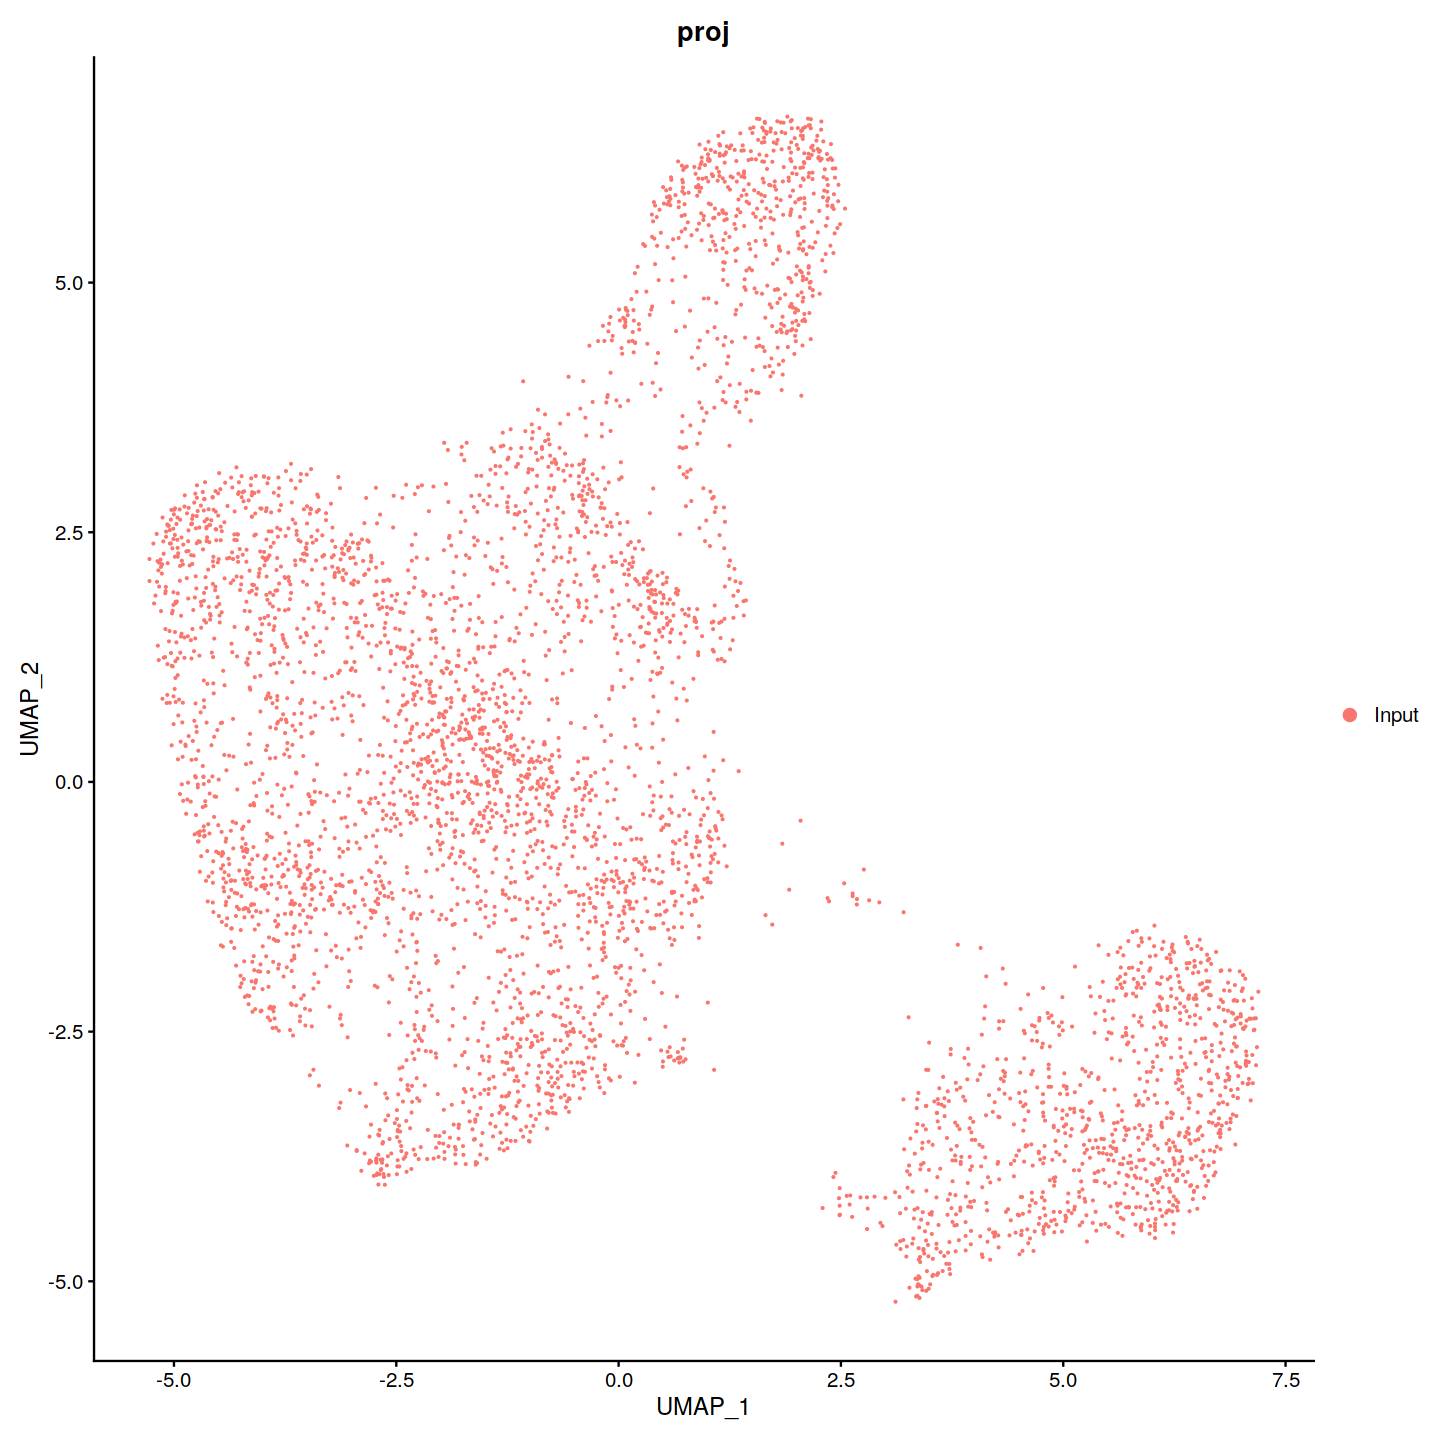

In [16]:
# Binarize and run LSI
combined <- BinarizeCounts(combined)
combined <- RunTFIDF(combined)
combined <- RunSVD(combined)
combined <- RunUMAP(combined, dims = lsi_start_comp:50, reduction = 'lsi')
DimPlot(combined, group.by = "proj", pt.size = 0.1)

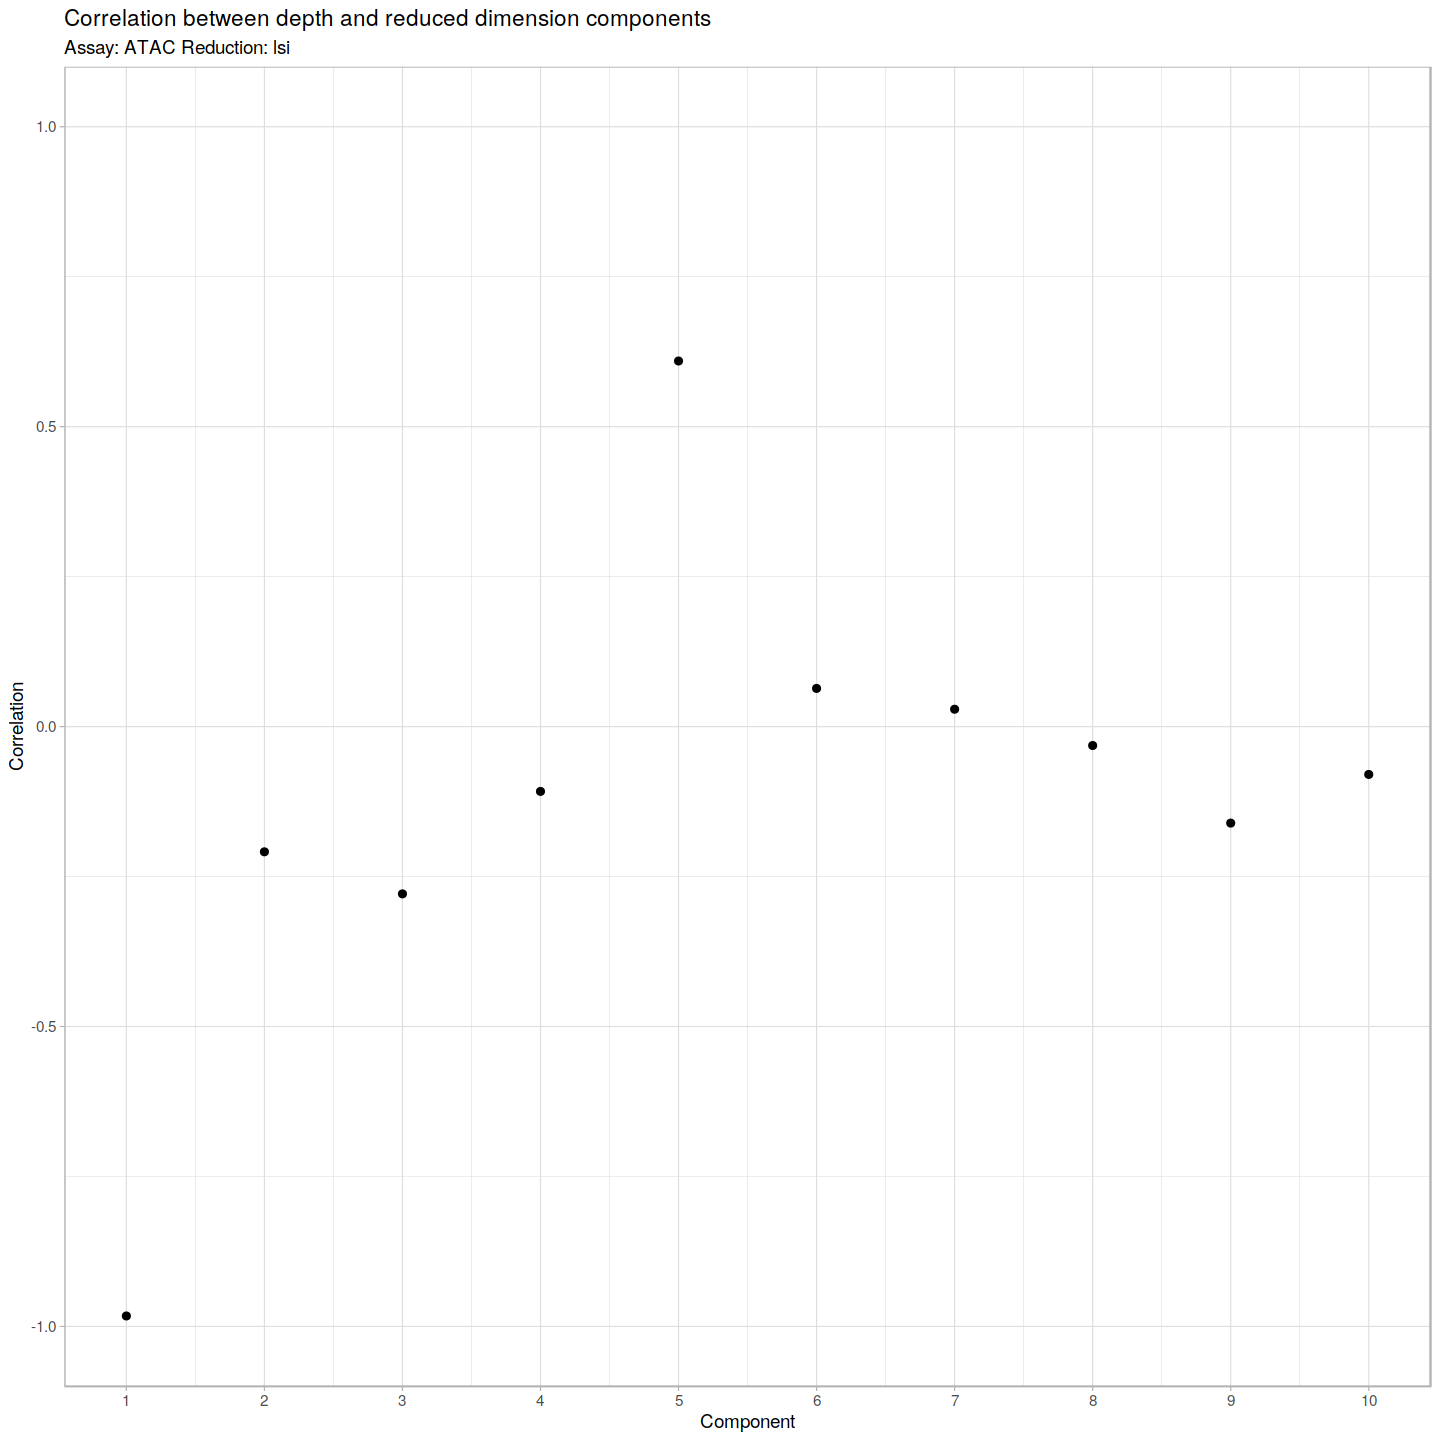

In [17]:
pDepthCorr <- DepthCor(combined)
pDepthCorr

In [18]:
allSE <- lapply(sample_names,  function(x) subset(combined, subset = orig.ident == x))
allSE

[[1]]
An object of class Seurat 
93059 features across 4657 samples within 1 assay 
Active assay: ATAC (93059 features, 87814 variable features)
 2 dimensional reductions calculated: lsi, umap


### Plot QC first

In [19]:

# qc <- function(se){
#     # add the gene information to the object
#     Annotation(se) <- annotations
#     gene.activities <- GeneActivity(se)
#     # compute nucleosome signal score per cell
#     se <- NucleosomeSignal(object = se)
    
#     # compute TSS enrichment score per cell
#     se <- TSSEnrichment(object = se, fast = FALSE)

#     # add blacklist ratio and fraction of reads in peaks
#     se$pct_reads_in_peaks <- se$peak_region_fragments / se$passed_filters * 100
#     se$blacklist_ratio <- se$blacklist_region_fragments / se$peak_region_fragments
#     se$high.tss <- ifelse(se$TSS.enrichment > 2, 'High', 'Low')
#     se$nucleosome_group <- ifelse(se$nucleosome_signal > 4, 'NS > 4', 'NS < 4')
#     TSSPlot(se, group.by = 'high.tss') + NoLegend()
#     ggsave(file=file.path(outdir, paste0("QC.TSS", se$orig.ident[[1]], ".png")))
#     FragmentHistogram(object = se, group.by = 'nucleosome_group')
#     ggsave(file=file.path(outdir, paste0("QC.FragHist", se$orig.ident[[1]], ".png")))
#     return(se)
# }

# if (to.qc){
#     #ggsave(file.path(outdir, paste0("QC_02.pdf")))
#     allSE <- lapply(allSE, qc)
#     allSE
#     #ggsave(file.path(outdir,"integrated.batch.png"), dpi=300)
#     }

# Integrate

## Run UMAP and plot

In [20]:
integrated = allSE[[1]]

In [21]:
p1 <- DimPlot(combined, group.by = "proj")

13:30:21 UMAP embedding parameters a = 0.9922 b = 1.112

13:30:21 Read 4657 rows and found 29 numeric columns

13:30:21 Using Annoy for neighbor search, n_neighbors = 30

13:30:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:30:22 Writing NN index file to temp file /tmp/RtmpnGyMle/file21e729759286c3

13:30:22 Searching Annoy index using 24 threads, search_k = 3000

13:30:22 Annoy recall = 100%

13:30:23 Commencing smooth kNN distance calibration using 24 threads

13:30:26 Initializing from normalized Laplacian + noise

13:30:26 Commencing optimization for 500 epochs, with 193446 positive edges

13:30:32 Optimization finished

Saving 6.67 x 6.67 in image



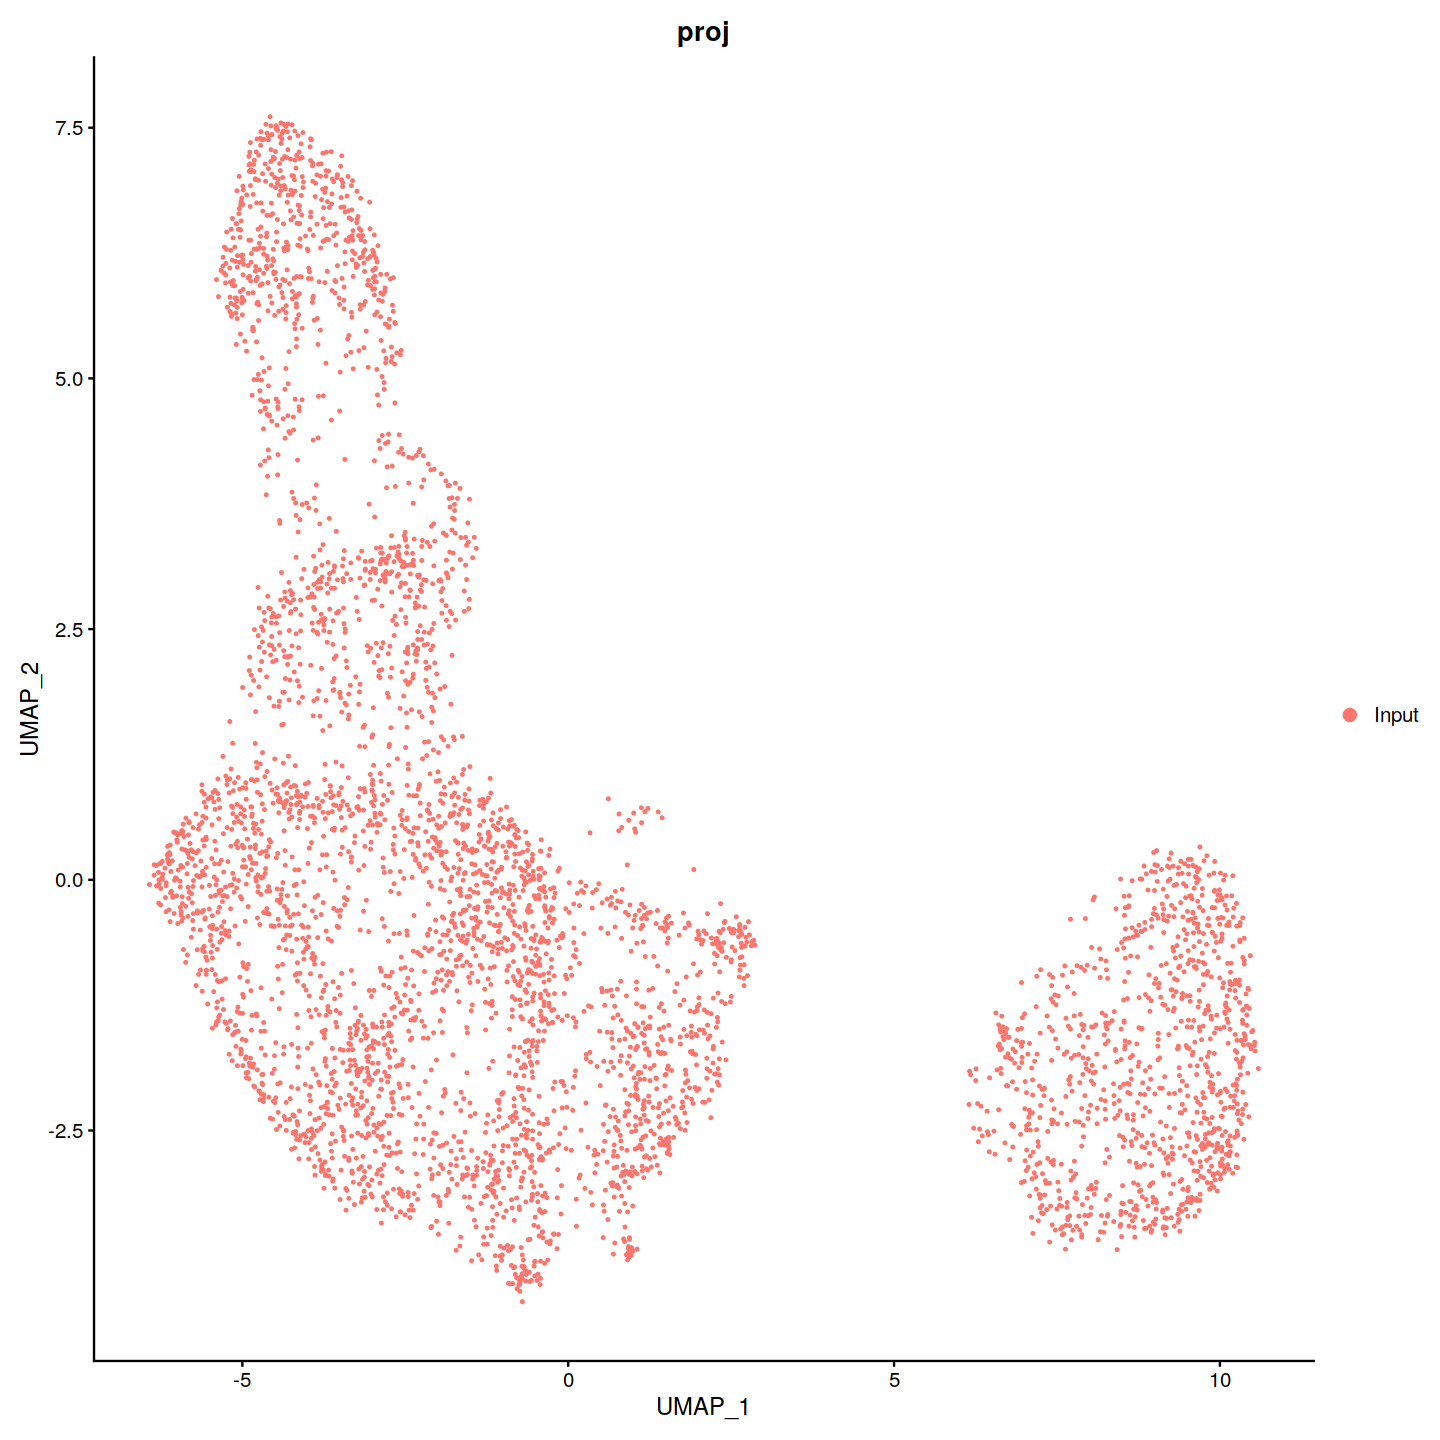

In [22]:
# create a new UMAP using the integrated embeddings
integrated <- RunUMAP(integrated, reduction = "lsi", dims = 2:30)
p2 <- DimPlot(integrated, group.by = "proj")
ggsave(file.path(outdir,"integrated.batch.png"), dpi=300)
p2

### Compare merged and integrated

Saving 6.67 x 6.67 in image



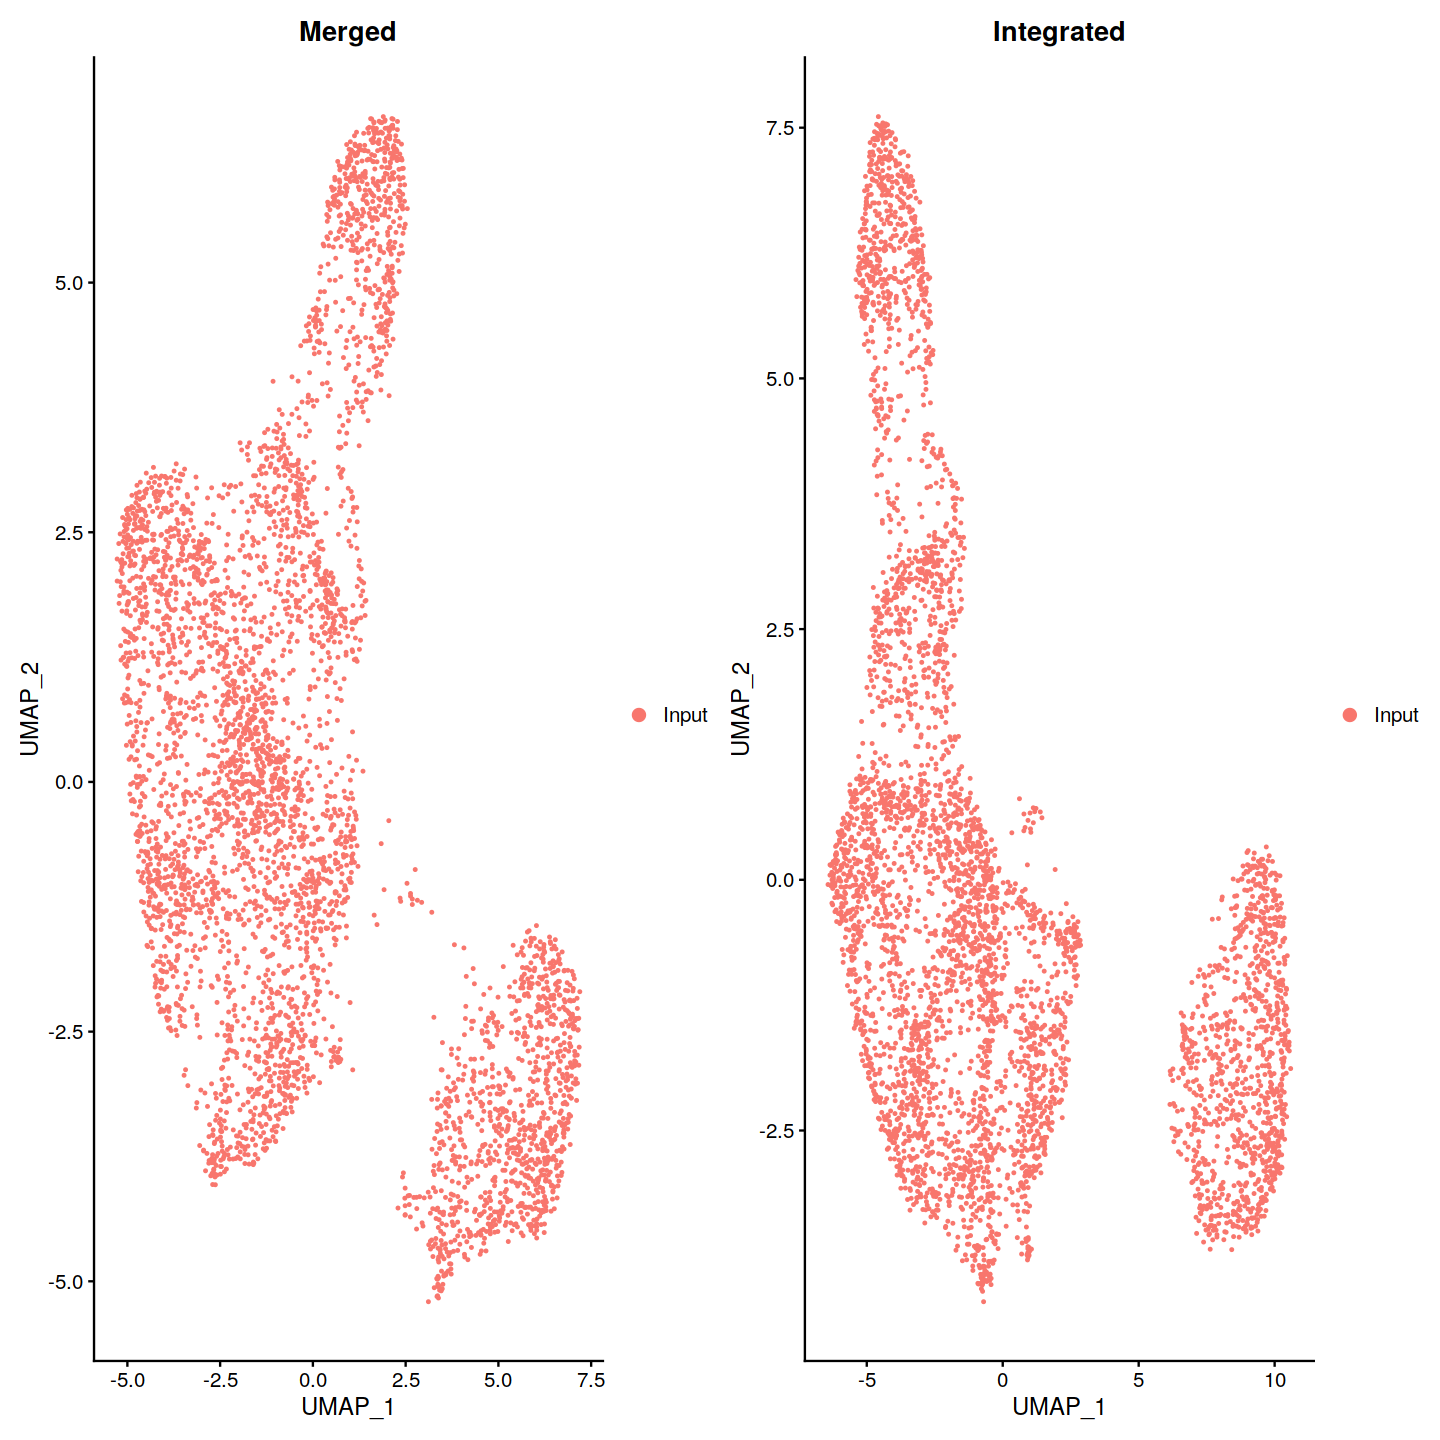

In [23]:
(p1 + ggtitle("Merged")) | (p2 + ggtitle("Integrated"))
ggsave(file.path(outdir,"integrated.merged.compare.png"), dpi=300)

## Correlation of LSI components and Depth

Saving 6.67 x 6.67 in image



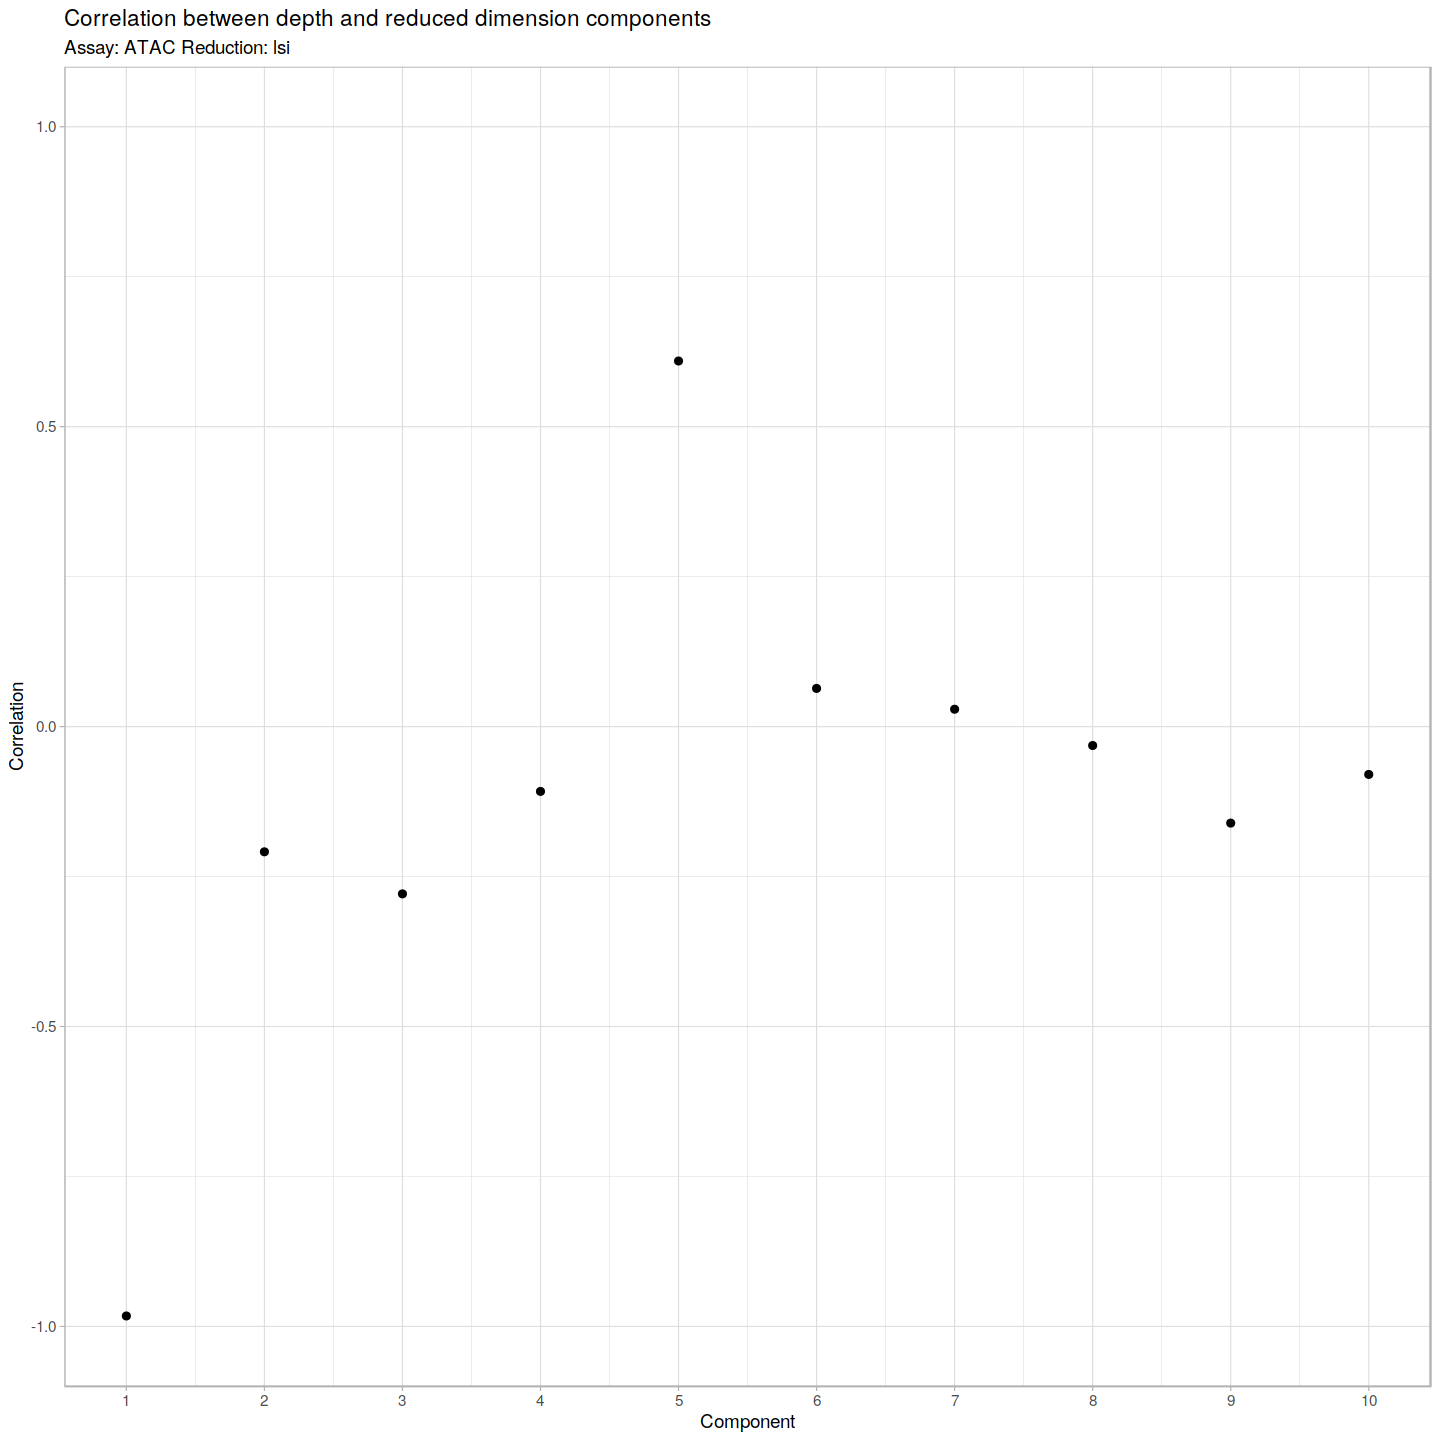

In [24]:
pDepthCorr <- DepthCor(integrated, reduction='lsi')
ggsave(file.path(outdir,"integrated.depthCor.png"), plot=pDepthCorr, dpi=300)

pDepthCorr

## Cluster and plot

Computing nearest neighbor graph

Computing SNN

Warning message:
"UNRELIABLE VALUE: One of the 'future.apply' iterations ('future_lapply-1') unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore"."
Saving 6.67 x 6.67 in image



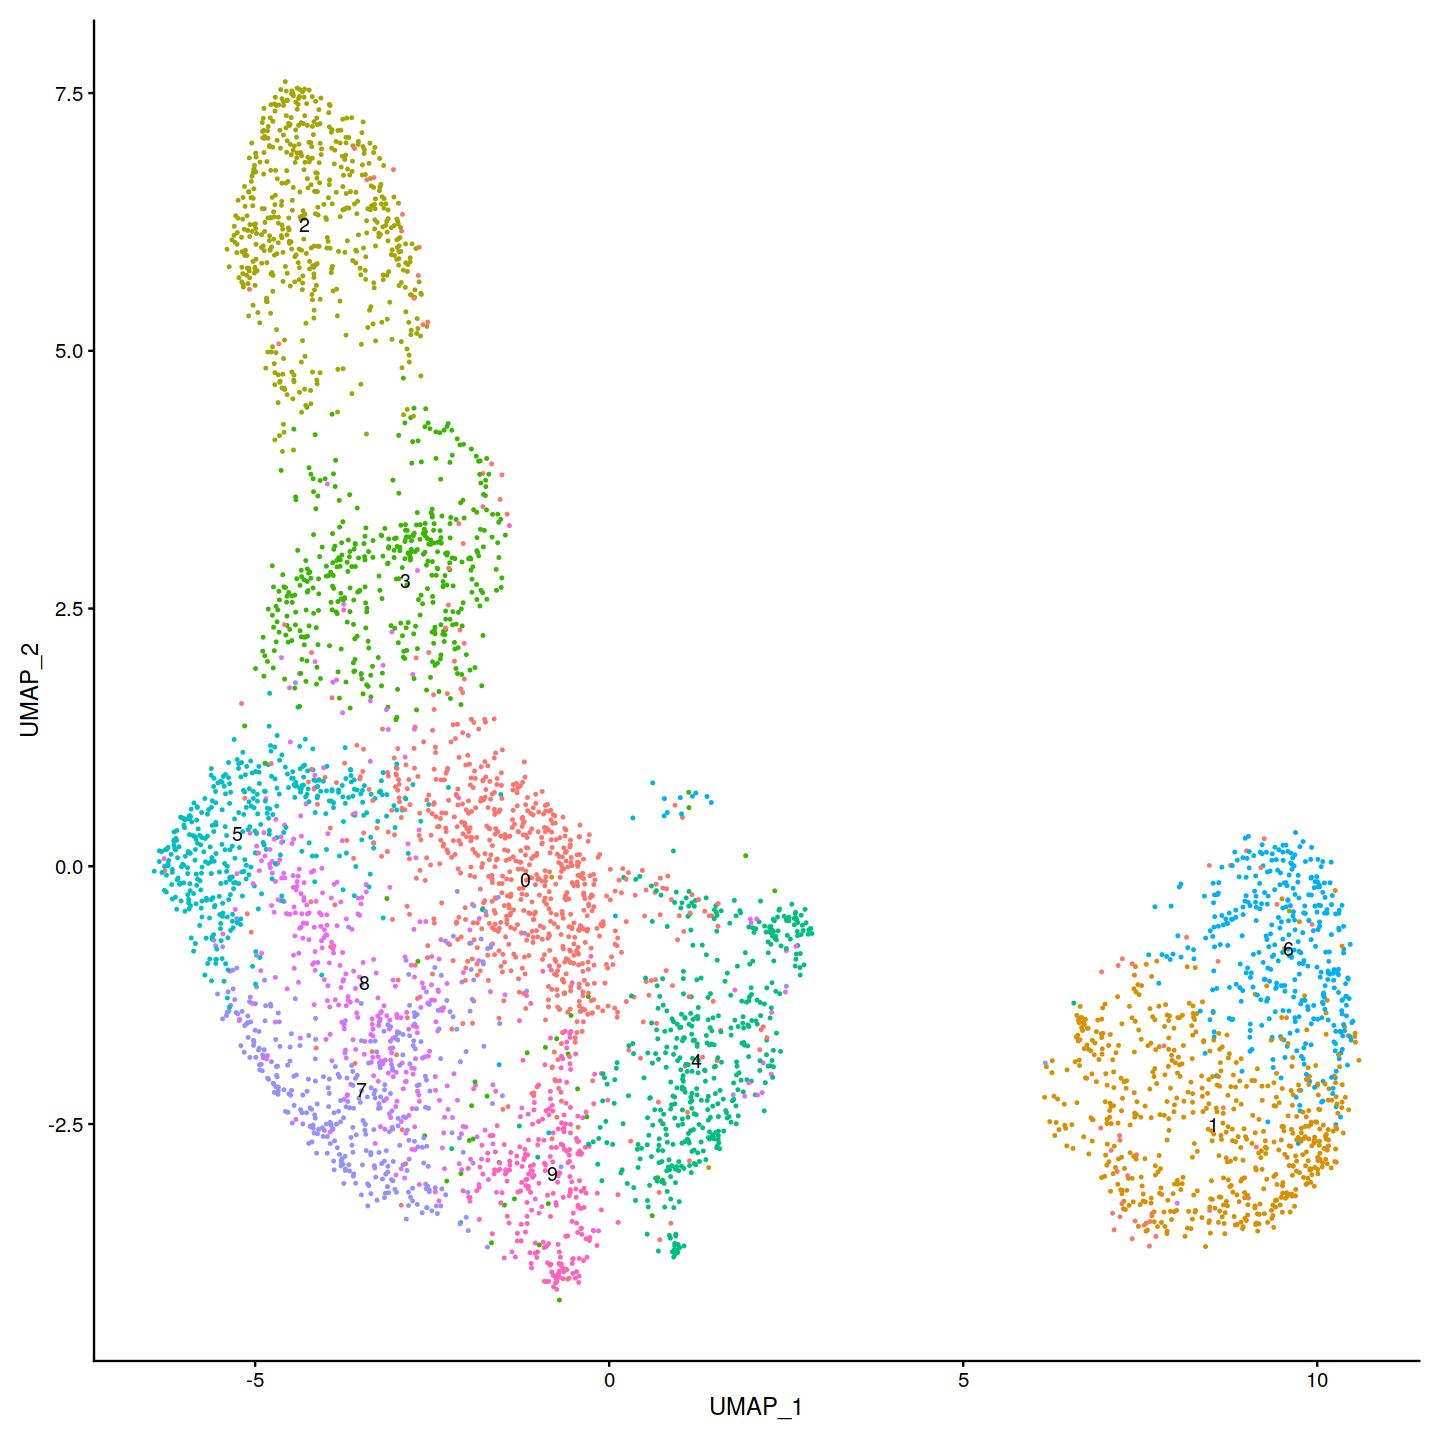

In [25]:
#integrated <- RunUMAP(object = integrated, reduction = 'lsi', dims = 2:30)
integrated <- FindNeighbors(object = integrated, reduction = 'lsi', dims = 2:30)
integrated <- FindClusters(object = integrated, verbose = FALSE, algorithm = 3)

pclust <- DimPlot(object = integrated, label = TRUE) + NoLegend()
ggsave(file.path(outdir, "integrated.lsi.clusters.png"), pclust)
pclust

## Get gene activity results 

In [26]:
# add the gene information to the object
DefaultAssay(integrated) <- "ATAC"
Annotation(integrated) <- annotations
gene.activities <- GeneActivity(integrated)


Extracting gene coordinates

Extracting reads overlapping genomic regions



## Remove MT genes

In [27]:
mt_genes <- annotations[seqnames(annotations) == "chrM"]
dim(mt_genes)


NULL

In [28]:
dim(gene.activities)

[1] 19039  4657

In [29]:
gene.activities <- gene.activities[!(rownames(gene.activities) %in% mt_genes$gene_name),]

In [30]:
dim(gene.activities)

[1] 19039  4657

In [31]:
# add the gene activity matrix to the Seurat object as a new assay and normalize it
integrated[['RNA']] <- CreateAssayObject(counts = gene.activities)
integrated <- NormalizeData(
  object = integrated,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(integrated$nCount_RNA)
)

In [32]:
DefaultAssay(integrated) <- 'RNA'

In [33]:
saveRDS(integrated, file.path(outdir, paste0("allSamples.integrated.rds")))

Saving 6.67 x 6.67 in image



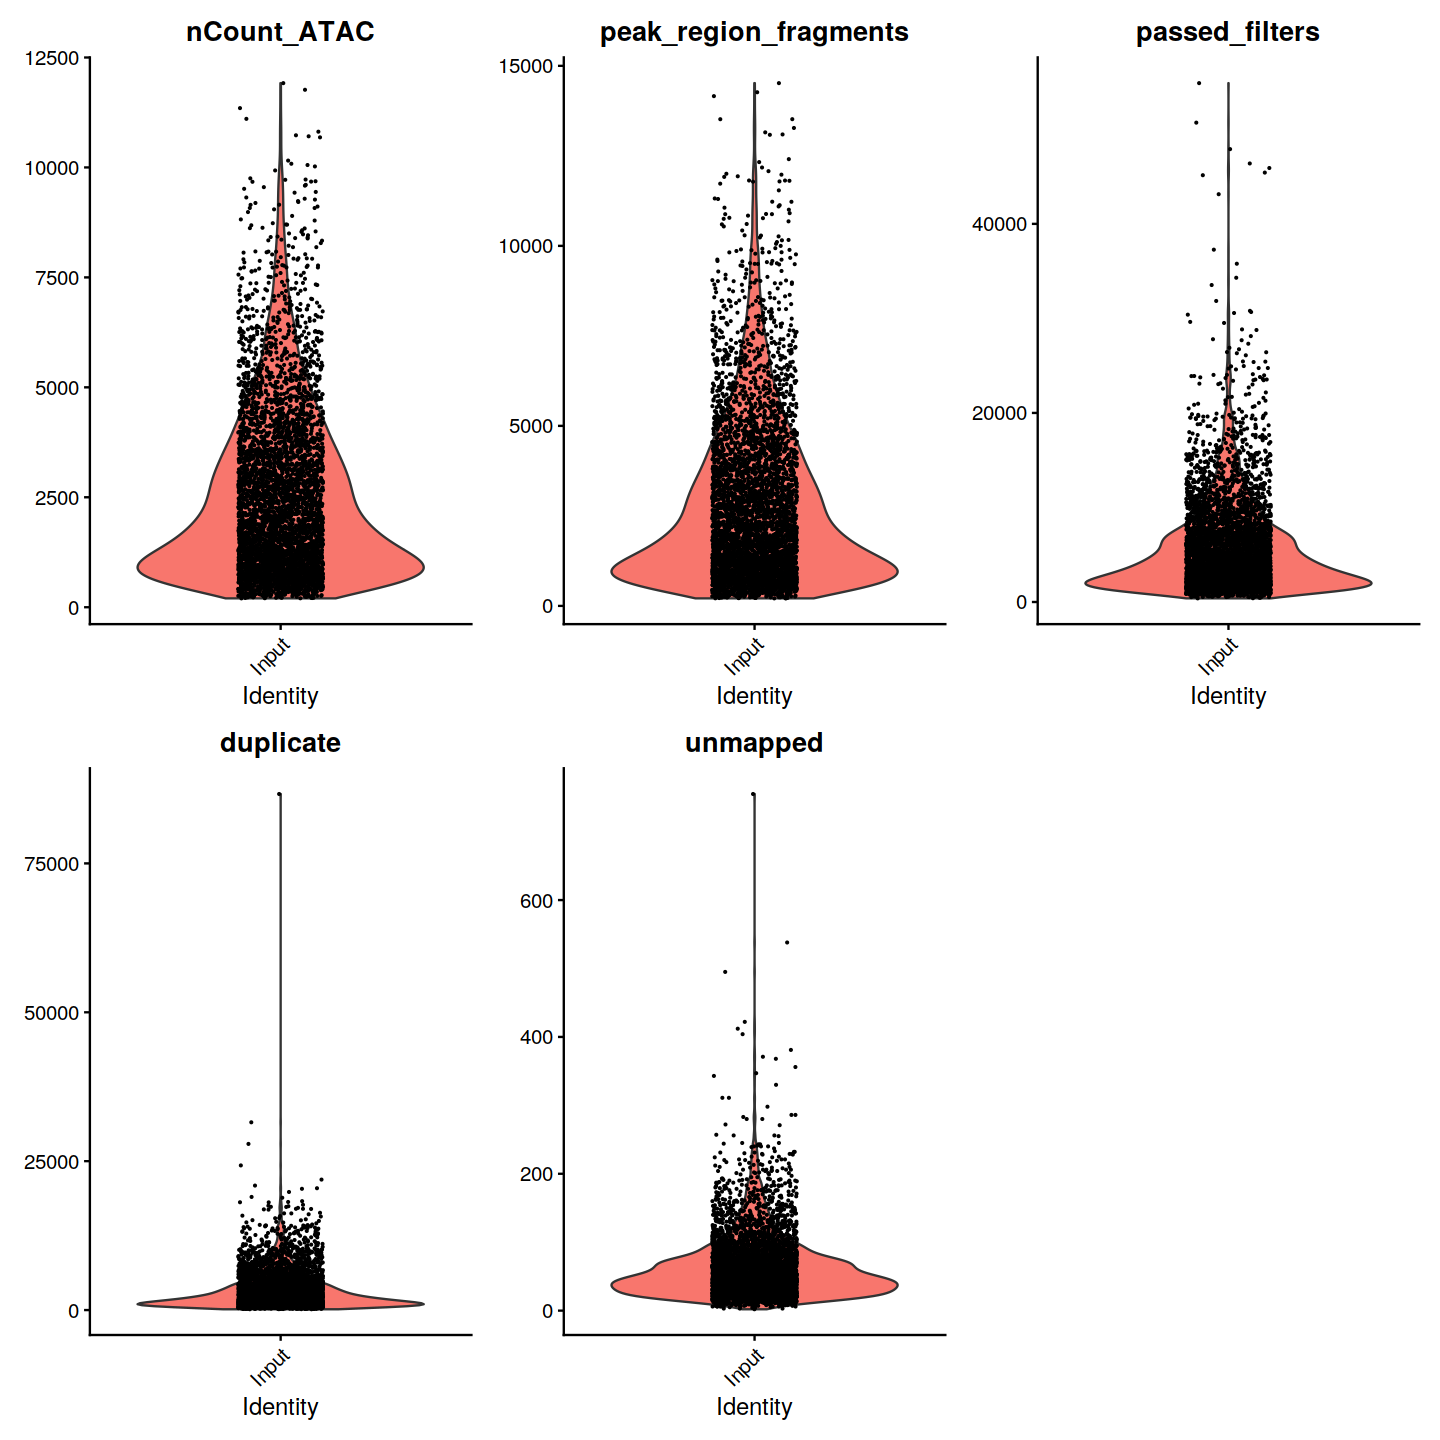

In [34]:
Idents(integrated) <- "orig.ident"
VlnPlot(
  object = integrated,
  features = c('nCount_ATAC', 'peak_region_fragments', 'passed_filters',
               'duplicate', 'unmapped'),
  split.by = "orig.ident",
  pt.size = 0.1,
  ncol = 3
)

ggsave(file.path(outdir, paste0("QC_02.png")))

In [35]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Rsamtools_2.10.0          Biostrings_2.62.0        
 [3] XVector_0.34.0            future_1.23.0            
 [5] dplyr_1.0.8               metap_1.1                
 [7] cowplot_1.1.1             magrittr_2.0.2           
 [9] data.table_1.14.2         patchwork_1.1.1          
[11] 